# 1. ViT Preprocessing

The goal of this tutorial is to set set up a basic Vision Transformer model from scrath using Pytorch in order to understand the basic principles and theoretical background. The tutorial combines concepts from https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c and https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51. This first of three notebooks deals with the preprocessing of images.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch import Tensor
from torch import nn

## MNIST Data Set Preparation

Similar to the Tensorflow / Keras examples, we'll start out with the preperation of the data set. To keep things simple and comparable, the MNIST dat aset is used here again.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 877052.45it/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 140256.76it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 668597.02it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4570664.29it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Image shape is: torch.Size([32, 1, 28, 28]) (batch size, channels, height, width)


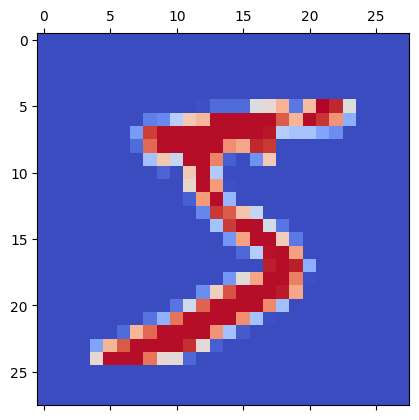

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# INFO: The PyTorch uses a different tensor shape than Tensorflpow
# Tensorflow: [batch_size, height, width, channels]
# Pytorch: [batch_size, channels, height, width]
train_loader = DataLoader(training_data, batch_size=32)
x_sample, y_sample = next(iter(train_loader))
image_shape = x_sample.shape
print (f"Image shape is: {image_shape} (batch size, channels, height, width)")
plt.matshow(x_sample[0][0], cmap="coolwarm")
plt.savefig("MNIST_input.png", bbox_inches="tight", dpi=200)
plt.show()

## Patchifier

Firstly, all images have to be divided into patches for the following embedding. We'll generate a class that inherits from nn.Module which takes care of most deep learning related operations in the background. We'll only define the necessery parameters in the __init__ and the forward pass operations when the module is called. Pytorch models can be assembled using nn.Modules

In [4]:
class Patchifyer(nn.Module):
    """
    A class to handle patchifying images, derived from nn.Module.
    
    Attributes:
        channels (int): Number of channels in the input images.
        p_size (int): Size of the patches the images will be divided into.
    """
    def __init__(self, image_shape, p_size):
        """
        Initialize the Patchifyer.

        Args:
            image_shape (tuple): Shape of the input images (N, C, H, W).
            p_size (int): Size of the patches.
        """
        super().__init__() # TODO somit kann man die eltern klass initializieren 
        self.channels = image_shape[1]
        self.p_size = p_size
        
    def forward(self, images):
        """
        Forward pass to patchify the input images.
        This method is used when the class is called.

        Args:
            images (tensor): A batch of images.
        Returns:
            Tensor: Patchified images.
        """
        patches = images.unfold(2, self.p_size, self.p_size).unfold(3, self.p_size, self.p_size)
        patches = patches.reshape(images.shape[0], -1, self.channels, self.p_size, self.p_size)
        return patches

This is how the Patchifyier works on the above example image.

Shape after patchifying: torch.Size([32, 16, 1, 7, 7]) (batch size, number of patches, channels, patch height, patch width)


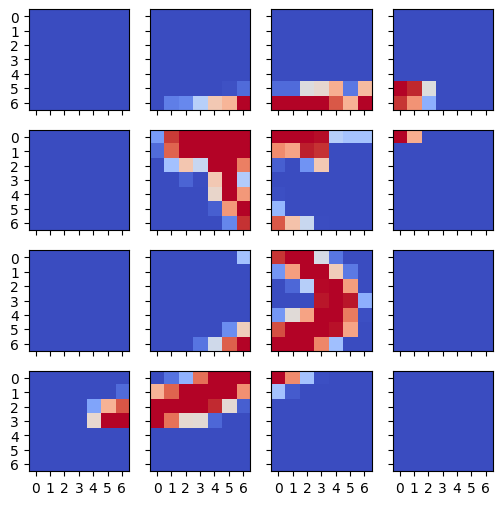

In [5]:
# We'll divide the images into ptches of seven pixels size resulting in 4x4=16 patches
patchify = Patchifyer(x_sample.shape, p_size=7)
patch_data = patchify(x_sample) # TODO: Somit wurde the forward auufgerung con der patchify(_) aber forward!
patch_shape = patch_data.shape
print (f"Shape after patchifying: {patch_shape} (batch size, number of patches, channels, patch height, patch width)")

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True)
fig.set_figwidth(6)
fig.set_figheight(6)

for (i, j), ax in np.ndenumerate(axes):
    ax.matshow(patch_data[0][i*4+j, 0, :, :], cmap="coolwarm")
    ax.xaxis.tick_bottom()

plt.savefig("MNIST_patchified.png", bbox_inches="tight", dpi=200)

In [6]:
class LinearEmbedding(nn.Module):
    """
    A class for linear embedding of image patches, derived from nn.Module.

    Attributes:
        in_dimension (int): Dimension of input data.
        embedded_dimension (int): Dimension of the output embedded data.
    """
    def __init__(self, in_dimension, embedded_dimension):
        """
        Initialize the LinearEmbedding.

        Args:
            in_dimension (int): Dimension of each flattened patch.
            embedded_dimension (int): Desired dimension of the embedded vectors.
        """
        super().__init__()
        self.in_dimension = in_dimension
        self.embedded_dimension = embedded_dimension

        self.embedding = nn.Linear(self.in_dimension, self.embedded_dimension)

    def forward(self, patches):
        """
        Forward pass to embed the input patches.

        Args:
            patches (tensor): A batch of image patches.
        Returns:
            Tensor: Embedded representation of input patches.
        """
        flattened_data = patches.flatten(start_dim=2) # hier werden die diemensionen flach gemacht 
        tokens = self.embedding(flattened_data)
        return tokens

We could embed our patched images in just two dimension in order to plot them. In the application the embedded space is of mauch higher dimension of course. For now the weights of the embedding layer are initialized randomly. Later they will be trained with the rest of the ViT.

Through the embedding each image patch can be represented by a set of numbers. Once the patches are embedded, they can be treated similarly to the language tokens of the original NLP Transformer. Hence, the embedded image patches are often referred to as tokens, too.

In [7]:
tokenizer = LinearEmbedding(patch_data.shape[-1]**2, 2) # todo: hier projektieren wir alles in 2 dimensiion
tokens = tokenizer(patch_data)
print(f"Shape of image tokens after the embedding: {tokens.shape} (batch size, number of patches / tokens, embedded dimension)")

# torch.Size([32, 16, 2]) : 

Shape of image tokens after the embedding: torch.Size([32, 16, 2]) (batch size, number of patches / tokens, embedded dimension)


Visualizing the two embedded dimensions. Again, in real applications the embedded dimension is much higher than here and the weights are trained such that the embedded representation is much more meaningful.

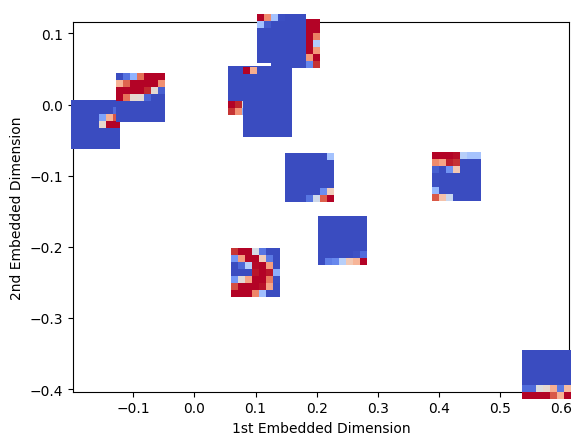

In [8]:
def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    digits = list()
    for x0, y0, im in zip(x, y, images):
        im = OffsetImage(im, zoom=zoom, cmap="coolwarm")
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        digits.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return digits

example_tokens = tokens[0].detach()
example_images = patch_data[0, :, 0, ...]
fig, ax = plt.subplots()
imscatter(example_tokens[:, 0],
          example_tokens[:, 1],
          example_images,
          zoom=5,
          ax=ax)
ax.set_xlabel("1st Embedded Dimension")
ax.set_ylabel("2nd Embedded Dimension")
plt.savefig("MNIST_embedded.png", bbox_inches="tight", dpi=200)
plt.show()
# bis jetzt noch random für die klass token 

## Adding a Learnable Class Token

ViT are sequence-to-sequence analyzer by their roots. In order to perform a classification task we need to add a learnable token to each input image in the batch. This token will be trained to contain classification logits in the end and will be read out by a final layer.

In [9]:
print(f"Shape of image tokens: {tokens.shape}")

# Generating a class token for each image in the batch
class_token = nn.Parameter(torch.rand(32, 1, 2))
print(f"Shape of class tokens: {class_token.shape}")

# The class tokens are concatenated to the image tokens
# and increases the the token dimension by one (e.g. 17: 16 image tokens + 1 class token each)
result_tokens = torch.cat((tokens, class_token), dim=1) # todo hier hängen wir die token und class tokken zusammen 
print(f"Resulting shape for the concatenated class tokens: {result_tokens.shape}")

Shape of image tokens: torch.Size([32, 16, 2])
Shape of class tokens: torch.Size([32, 1, 2])
Resulting shape for the concatenated class tokens: torch.Size([32, 17, 2])


## Positional Encoding'

Tranformers calculate all combinations of similarities between the patches / tokens and would loose positional information in the process. The position of a patch / token can however contain relevant information for the classification task. To prevent that loss of positional information, we superimpose a unique, position-sensitive pattern on top of each token. In this way the position of each token in the original image is encoded in the token.

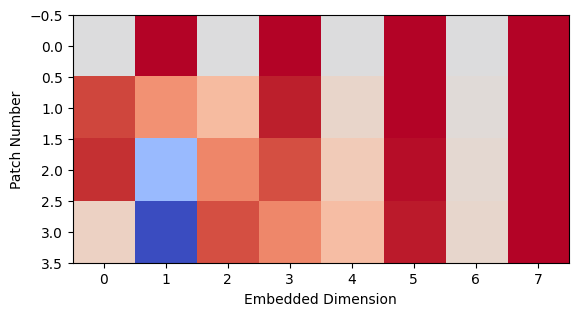

In [10]:
def get_positional_embeddings(sequence_length, embedded_dimension):
    """
    Generate positional embeddings for a sequence.
    The embeddings are generated using alternating sine and cosine functions 
    of different frequencies.

    Args:
        sequence_length (int): Length of the sequence to generate embeddings for.
        embedded_dimension (int): Dimensionality of the embeddings.

    Returns:
        Tensor: A tensor of shape (sequence_length, d) containing 
                he positional embeddings.
    """
    result = torch.ones(sequence_length, embedded_dimension)
    for i in range(sequence_length):
        for j in range(embedded_dimension):
            result[i][j] = np.sin(i / (100 ** (j / embedded_dimension))) if j % 2 == 0 else np.cos(i / (100 ** ((j - 1) / embedded_dimension)))
    return result

# plt.imshow(get_positional_embeddings(4, 8), cmap="coolwarm", interpolation="nearest")
plt.imshow(get_positional_embeddings(128, 128), cmap="coolwarm", interpolation="nearest")

plt.xlabel("Embedded Dimension")
plt.ylabel("Patch Number")
plt.savefig("pos_encoding.png", bbox_inches="tight", dpi=200)
plt.show()

If we plot only the positional encoding in two dimensions, without any underlying data embedding, it becomes a little clearer, that the positional encodiong projects all patches onto a unit circle, and thus assings each patch a unique position.

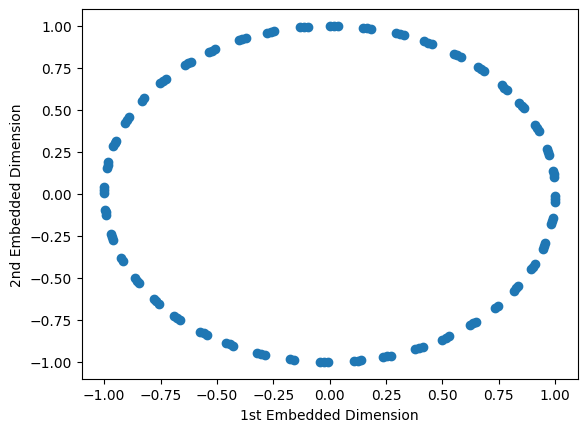

In [11]:
encoding_2d = get_positional_embeddings(128, 2)
plt.scatter(encoding_2d[:, 0], encoding_2d[:, 1])

plt.xlabel("1st Embedded Dimension")
plt.ylabel("2nd Embedded Dimension")
plt.savefig("pos_encoding_2D.png", bbox_inches="tight", dpi=200)
plt.show()

## Assembling all parts

Now all necessary preprocessing modules and functions are defined. We'll assemble them in another nn.Module for later use.

In [12]:
class VitPreprocessor(nn.Module):
    """
    A class for preprocessing images for Vision Transformer (ViT), derived from nn.Module.
    It includes patchifying the images, applying linear embedding, adding a learnable 
    classification token, and adding positional encoding.

    Attributes:
        image_shape (tuple): Shape of the input images.
        p_size (int): Size of the patches.
        embedded_dimension (int): Dimension of the embedded patches.
        n_patches (int): Number of patches per image.
        patchifier (Patchifyer): Patchifying layer.
        tokenizer (LinearEmbedding): Linear embedding layer.
        class_token (nn.Parameter): Learnable classification token.
        positional_embedding (torch.Tensor): Positional embeddings.
    """
    def __init__(self, image_shape, p_size, embedded_dimension):
        """
        Initialize the VitPreprocessor.

        Args:
            image_shape (tuple): Shape of the input images (N, C, H, W).
            p_size (int): Size of the patches each image is divided into.
            embedded_dimension (int): Dimension of the embeddings after linear transformation.
        """
        super().__init__()
        self.image_shape = image_shape
        self.channels = image_shape[1]
        self.embedded_dimension = embedded_dimension
        self.p_size = p_size
        self.n_patches = (self.image_shape[2] // self.p_size) ** 2

        # 1) Patchify Images
        self.patchifer = Patchifyer(self.image_shape, self.p_size)
        
        # 2) Linear Embedding
        self.tokenizer = LinearEmbedding(self.p_size ** 2, self.embedded_dimension)

        # 3) Adding a learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, 1, self.embedded_dimension))

        # 4) Positional Econding
        self.positional_embedding = get_positional_embeddings(self.n_patches + 1, self.embedded_dimension)

    def forward(self, images):
        """
        Forward pass of the VitPreprocessor.

        Args:
            images (torch.Tensor): A batch of images.

        Returns:
            torch.Tensor: Processed tokens ready for the Transformer model.
        """
        patches = self.patchifer(images)
        tokens = self.tokenizer(patches)
    
        # Adding classification token to the tokens
        batch_class_token = self.class_token.repeat(images.shape[0], 1, 1) #todo wir erzeugen eine klass tokem und wirderholen es 
        tokens = torch.cat((tokens, batch_class_token), dim=1)
    
        # Adding positional embedding
        positional_embedding = self.positional_embedding.repeat(images.shape[0], 1, 1)
        out = tokens + self.positional_embedding
        return out

## Example Processing

Let's visualize our result. We'll process an example batch through the whole preprocessing pipline and visualize the results. Please note how the patches have changed their position in the embedded space due to the positional encoding.

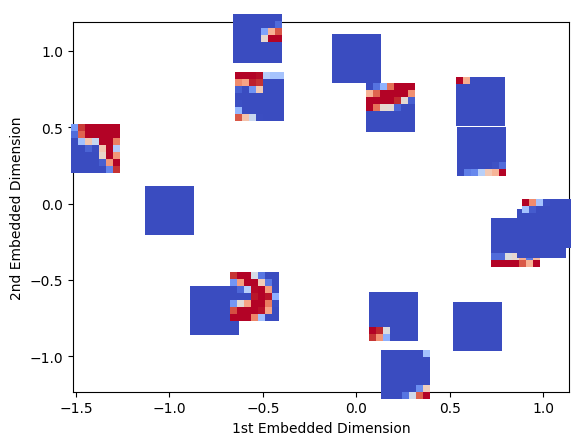

In [13]:
vit_preprocessor = VitPreprocessor(x_sample.shape, p_size=7, embedded_dimension=2)
vit_input = vit_preprocessor(x_sample)

# In Pytorch we can extract values from a computational graph at inference time by calling the .numpy() method.
# Pytorch contains modules, however, that automatically trace tensors and calculate gradients for backpropagation.
# If we only want to read out the values in a tensor that requires gradients,
# we need to detach the tensor from that graph. Thus, whatever we'll do with the values, it doesn't influence the grandients.
# To that end use detach() to generate a copy of the tensor containing the values that exists outside the model graph.
example_tokens = vit_input[0].detach().numpy()
example_images = patch_data[0, :, 0, ...]
fig, ax = plt.subplots()
imscatter(example_tokens[:, 0],
          example_tokens[:, 1],
          example_images,
          zoom=5,
          ax=ax)
ax.set_xlabel("1st Embedded Dimension")
ax.set_ylabel("2nd Embedded Dimension")
plt.savefig("MNIST_embedded_enc.png", bbox_inches="tight", dpi=200)
plt.show()